In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import seaborn as sns
from scipy.optimize import minimize

# Enable interactive plots


In [2]:
import warnings

warnings.filterwarnings('error', category=np.ComplexWarning)

## Sytem Model

## Channel Model

#### Distance matrices

![Location setup](../location.png)


In [3]:
# 2nd irs is in same plane but
# shift to right by d_ris_ris_x distance form first one,(negative means shifted to left)
# shift to up by d_ris_ris_y distance form first one,(negative means shifted to down)

def rotate_z_clockwise(x, y, z, angle, center):
    x0, y0, z0 = center
    theta = np.deg2rad(angle)
    cos_t = np.cos(theta)
    sin_t = np.sin(theta)
    
    # Translate to origin
    x_shifted = x - x0
    y_shifted = y - y0
    z_shifted = z - z0  # z will stay same, but keep for clarity
    
    # Rotate
    x_rot = x_shifted * cos_t + y_shifted * sin_t
    y_rot = -x_shifted * sin_t + y_shifted * cos_t
    z_rot = z_shifted
    
    # Translate back
    x_final = x_rot + x0
    y_final = y_rot + y0
    z_final = z_rot + z0
    
    return x_final, y_final, z_final

def Coordinates_system(Nt, lt, Nr, lr, Na_1, Nb_1, d_ris, Na_2, Nb_2, d_irs_irs_x, d_irs_irs_y, D, wavelength):

    # Spacing between antennas (in meters)
    antenna_spacing = wavelength/2

    ######################################################################################################
    # Tx coordinates
    # x,y coordinates is zeros
    tx_antenna_x_coor = np.ones(Nt) * 0
    tx_antenna_y_coor = np.arange(Nt-1, -1, -1) * antenna_spacing + lt - ((Nt-1) * antenna_spacing)/2
    tx_antenna_z_coor = np.ones(Nt) * 0


    ######################################################################################################
    # Rx coordinates
    # x coordinate is D
    # y coordinate is zeros
    rx_antenna_x_coor = np.ones(Nr) * D
    rx_antenna_y_coor = np.arange(Nr-1, -1, -1) * antenna_spacing + lr - ((Nr-1) * antenna_spacing)/2
    rx_antenna_z_coor = np.ones(Nr) * 0


    ######################################################################################################
    # RIS coordinates
    # on x axis we have Na elements
    # on y axis we have Nb elements

    # RIS y coordinates are zero
    # RIS 2 x coordinates 
    col = np.arange(0, Na_1, 1).reshape(-1, 1)
    col = np.tile(col, Nb_1) * antenna_spacing + d_ris - ((Na_1-1) * antenna_spacing)/2
    ris_elements_x_coor_1 = col.reshape(-1,)

    ris_elements_y_coor_1 = np.ones(Na_1*Nb_1) * 0

    # RIS 2 y coordinates 
    col = np.arange(0, Nb_1, 1)
    col = np.tile(col, Na_1) * antenna_spacing - ((Nb_1-1) * antenna_spacing)/2
    ris_elements_z_coor_1 = col.reshape(-1,)

    
    ris_elements_x_coor_1, ris_elements_y_coor_1, ris_elements_z_coor_1 = rotate_z_clockwise(
        ris_elements_x_coor_1, ris_elements_y_coor_1, ris_elements_z_coor_1,
        45, 
        ((ris_elements_x_coor_1[-1] + ris_elements_x_coor_1[0])/2,
        (ris_elements_y_coor_1[-1] + ris_elements_y_coor_1[0])/2, 
        (ris_elements_z_coor_1[-1] + ris_elements_z_coor_1[0])/2)

    )



    # ##################################################
    # ris 2
    col = np.arange(0, Na_2, 1).reshape(-1, 1)
    col = np.tile(col, Nb_2) * antenna_spacing + (d_ris + d_irs_irs_x) - ((Na_2-1) * antenna_spacing)/2
    ris_elements_x_coor_2 = col.reshape(-1,)

    ris_elements_y_coor_2 = np.ones(Na_2*Nb_2) * d_irs_irs_y

    # RIS y coordinates 
    col = np.arange(0, Nb_2, 1)
    col = np.tile(col, Na_2) * antenna_spacing - ((Nb_2-1) * antenna_spacing)/2
    ris_elements_z_coor_2 = col.reshape(-1,)

    ris_elements_x_coor_2, ris_elements_y_coor_2, ris_elements_z_coor_2 = rotate_z_clockwise(
        ris_elements_x_coor_2, ris_elements_y_coor_2, ris_elements_z_coor_2,
        -45, 
        ((ris_elements_x_coor_2[-1] + ris_elements_x_coor_2[0])/2,
        (ris_elements_y_coor_2[-1] + ris_elements_y_coor_2[0])/2, 
        (ris_elements_z_coor_2[-1] + ris_elements_z_coor_2[0])/2)

    )

    return [
        tx_antenna_x_coor,
        tx_antenna_y_coor,
        tx_antenna_z_coor,
        rx_antenna_x_coor,
        rx_antenna_y_coor,
        rx_antenna_z_coor,
        ris_elements_x_coor_1,
        ris_elements_y_coor_1,
        ris_elements_z_coor_1,
        ris_elements_x_coor_2,
        ris_elements_y_coor_2,
        ris_elements_z_coor_2
    ]
    
# Caluating distance vectors to be used in calulating path losses
# generate N1xN2 size distance matrix
# i,j elements refer to distance between ith element in mat1 and jth element in mat2
def CalCulateDistance(N1, N2, mat1_x, mat1_y, mat1_z, mat2_x, mat2_y, mat2_z):
    distance_matrix = np.zeros((N1, N2))

    for n1 in range(N1):
        for n2 in range(N2):
            distance_matrix[n1,n2] = np.sqrt(
                (mat1_x[n1] - mat2_x[n2]) ** 2 +
                (mat1_y[n1] - mat2_y[n2]) ** 2 +
                (mat1_z[n1] - mat2_z[n2]) ** 2 
            )

    return distance_matrix


def GenerateDistanceMatrix(Nt, lt, Nr, lr, Na_1, Nb_1, d_ris, Na_2, Nb_2, d_irs_irs_x, d_irs_irs_y, D, wavelength):
    N_ris_1 = Na_1 * Nb_1
    N_ris_2 = Na_2 * Nb_2
    
    # Rx and Tx
    [
        tx_antenna_x_coor,
        tx_antenna_y_coor,
        tx_antenna_z_coor,
        rx_antenna_x_coor,
        rx_antenna_y_coor,
        rx_antenna_z_coor,
        ris_elements_x_coor_1,
        ris_elements_y_coor_1,
        ris_elements_z_coor_1,
        ris_elements_x_coor_2,
        ris_elements_y_coor_2,
        ris_elements_z_coor_2
    ] = Coordinates_system(Nt, lt, Nr, lr, Na_1, Nb_1, d_ris, Na_2, Nb_2, d_irs_irs_x, d_irs_irs_y, D, wavelength)

    

    # Create traces for each variable
    trace1 = go.Scatter3d(x=tx_antenna_x_coor, y=tx_antenna_y_coor, z=tx_antenna_z_coor, mode='markers', marker=dict(size=5, color='red'), name='Tx')
    trace2 = go.Scatter3d(x=rx_antenna_x_coor, y=rx_antenna_y_coor, z=rx_antenna_z_coor, mode='markers', marker=dict(size=5, color='green'), name='Rx')
    trace3 = go.Scatter3d(x=ris_elements_x_coor_1, y=ris_elements_y_coor_1, z=ris_elements_z_coor_1, mode='markers', marker=dict(size=5, ), name='RIS1')
    trace4 = go.Scatter3d(x=ris_elements_x_coor_2, y=ris_elements_y_coor_2, z=ris_elements_z_coor_2, mode='markers', marker=dict(size=5, ), name='RIS2')

    # Create the figure
    fig = go.Figure(data=[trace1, trace2, trace3, trace4])

    # Add axis labels
    fig.update_layout(
        title='3D Plot of Multiple Variables',
        scene=dict(
            xaxis_title='X-axis',
            yaxis_title='Y-axis',
            zaxis_title='Z-axis'
        )
    )

    # Show the plot
    fig.show()

    
    distance_r_t = CalCulateDistance(Nr, Nt, 
        rx_antenna_x_coor, rx_antenna_y_coor, rx_antenna_z_coor,
        tx_antenna_x_coor, tx_antenna_y_coor, tx_antenna_z_coor
    )

    # Ris 1 and Tx
    distance_ris_1_t = CalCulateDistance(N_ris_1, Nt, 
        ris_elements_x_coor_1, ris_elements_y_coor_1, ris_elements_z_coor_1,
        tx_antenna_x_coor, tx_antenna_y_coor, tx_antenna_z_coor
    )

    # RIS 1 and Rx
    distance_r_ris_1 = CalCulateDistance(Nr, N_ris_1, 
        rx_antenna_x_coor, rx_antenna_y_coor, rx_antenna_z_coor,
        ris_elements_x_coor_1, ris_elements_y_coor_1, ris_elements_z_coor_1
    )

    # Ris 2 and Tx
    distance_ris_2_t = CalCulateDistance(N_ris_2, Nt, 
        ris_elements_x_coor_2, ris_elements_y_coor_2, ris_elements_z_coor_2,
        tx_antenna_x_coor, tx_antenna_y_coor, tx_antenna_z_coor
    )

    # RIS 2 and Rx
    distance_r_ris_2 = CalCulateDistance(Nr, N_ris_2, 
        rx_antenna_x_coor, rx_antenna_y_coor, rx_antenna_z_coor,
        ris_elements_x_coor_2, ris_elements_y_coor_2, ris_elements_z_coor_2
    )

    distance_ris_2_ris_1 = CalCulateDistance(N_ris_2, N_ris_1,
        ris_elements_x_coor_2, ris_elements_y_coor_2, ris_elements_z_coor_2,
        ris_elements_x_coor_1, ris_elements_y_coor_1, ris_elements_z_coor_1
    )

    return [
        distance_r_t,
        distance_ris_1_t,
        distance_r_ris_1,
        distance_ris_2_t,
        distance_r_ris_2,
        distance_ris_2_ris_1
    ]



In [4]:
# alpha
# Free space pathloss exponent of the direct/indirect link, whose value is influenced by the obstacle present.
def GenHLOS(distance_matrix, wavelength):
    return np.exp(-1j * 2 * np.pi * distance_matrix / wavelength)


# N1, N2 is dimensions of distance matrix used to generate HLOS
def GenHNOLOS(N1, N2, varaince = 1):
    real_part = np.random.normal(0, np.sqrt(varaince/2), (N1, N2))
    imag_part = np.random.normal(0, np.sqrt(varaince/2), (N1, N2))

    return (real_part + 1j * imag_part)


# calculate general H 
def Calculate_H_LOSNLOS(N1, N2, distance_matrix, wavelength, racian_factor):
    H_D_LOS = GenHLOS(distance_matrix, wavelength)
    H_D_NLOS = GenHNOLOS(N1, N2, 2)
    H_LOSNLOS = (np.sqrt(racian_factor) * H_D_LOS + H_D_NLOS)

    return H_LOSNLOS


# calculate H DIR (Direct channel between tx and rx)
# alpha value is influenced by the obstacle present
def Calculate_H_DIR(Nr, Nt, distance_matrix_r_t, wavelength, alpha_dir, D, lt, lr, racian_factor):
    d_note = np.sqrt((D ** 2) + ((lt-lr) ** 2))
    beta_DIR = ((4 * np.pi / wavelength) ** 2) * (d_note ** alpha_dir)
    
    H_DIR = np.sqrt(1/(beta_DIR * (racian_factor + 1))) * Calculate_H_LOSNLOS(Nr, Nt, distance_matrix_r_t, wavelength, racian_factor)
    return H_DIR


def Calculate_H1(N_ris, Nt, distance_matrix_ris_t, wavelength, racian_factor, beta_INDIR_inverse):
    return  np.sqrt(beta_INDIR_inverse/(racian_factor + 1)) * Calculate_H_LOSNLOS(N_ris, Nt, distance_matrix_ris_t, wavelength, racian_factor)


def Calculate_H2(Nr, N_ris, distance_matrix_r_ris, wavelength, racian_factor):
    return np.sqrt(1/(racian_factor + 1)) * Calculate_H_LOSNLOS(Nr, N_ris, distance_matrix_r_ris, wavelength, racian_factor)


# calculate H INDIR (Infirect Direct channel between tx and rx)
def Calculate_H_INDIR(H1, H2, thetas, beta_INDIR_inverse):
    F_theta = np.diag(thetas)
    H_INDIR = np.matmul(H2, np.matmul(F_theta, H1))

    return H_INDIR


def Calculate_H(HDIR, HINDIR):
    return HDIR + HINDIR

    

In [5]:
def Calculate_Z(H_dir, H1_1_,H1_2_, H1_3_, H1_4_, H2_1_, H2_2_, H2_3_, H2_4_, thetas_1, thetas_2, Q, kappa):
    return H_dir + \
        H2_1_ @ np.diag(thetas_1) @ H1_1_ + H2_2_ @ np.diag(thetas_2) @ H1_2_ + \
        H2_3_ @ np.diag(thetas_1) @ H1_3_ * kappa

def Rate(H_dir, H1_1_,H1_2_, H1_3_, H1_4_, H2_1_, H2_2_, H2_3_, H2_4_, thetas_1, thetas_2, Q, kappa):

    Z = Calculate_Z(H_dir, H1_1_,H1_2_, H1_3_, H1_4_, H2_1_, H2_2_, H2_3_, H2_4_, thetas_1, thetas_2, Q, kappa)
    Nr = H_dir.shape[0]
    
    rate = np.real(np.log(np.linalg.det(np.eye(Nr) + Z @ Q @ Z.conj().T))) / np.log(2)
    return rate


## Projected Gradient Method

In [6]:
def Calculate_Kappa(H_dir, H2, H1, Pt):
    if H_dir.all() == 0:
        return 10
    else :
        return 10 * max(1, 1/np.sqrt(Pt)) * np.sqrt( np.linalg.norm(H_dir)/ np.linalg.norm(np.matmul(H2, H1)))
    
    
def Calculate_LTheta(a, b, Pt):
  """
  Calculates the value of L_theta^2 based on equation (32).

  Args:
    a: The value of 'a'.
    b: The value of 'b'.
    Pt: The value of 'Pt'.

  Returns:
    The calculated value of L_theta^2.
  """

  term1 = 2 * a * (b**5) + 4 * (a**2) * (b**2)
  term2 = (a**3) * b + 2 * a * (b**7) + 8 * (a**2) * (b**4)
  term3 = 3 * (a**3) * (b**3) + (a**4) + 4 * (a**2) * (b**6)
  term4 = 2 * (a**3) * (b**5) + 4 * (a**4) * (b**2)
  term5 = 4 * (a**4) * (b**4)

  return term1 + term2 * Pt + term3 * (Pt**2) + term4 * (Pt**3) + term5 * (Pt**4)


def Calculate_LQ(a, b, Pt):
  """
  Calculates the value of L_Q^2 based on equation (33).

  Args:
    a: The value of 'a'.
    b: The value of 'b'.
    Pt: The value of 'Pt'.

  Returns:
    The calculated value of L_Q^2.
  """

  term1 = (a**2) * (b**2) + (b**8) + 2 * a * (b**5)
  term2 = 2 * (a**2) * (b**4) + (a**3) * b + 2 * a * (b**7)
  term3 = (a**2) * (b**6) + 3 * (a**3) * (b**3)
  term4 = 2 * (a**3) * (b**5)

  return term1 + term2 * Pt + term3 * (Pt**2) + term4 * (Pt**3)


def L_constant(H_dir_bar, H1_bar, H2, kappa, Pt_bar):
    U_h1_bar, S_h1_bar, Vh_h1_bar = np.linalg.svd(H1_bar)
    U_h2, S_h2, Vh_h2 = np.linalg.svd(H2)
    U_H_dir_bar, S_H_dir_bar, Vh_H_dir_bar = np.linalg.svd(H_dir_bar)
    
    
    lambda_max_h1_bar = np.max(S_h1_bar)
    lambda_max_h2 = np.max(S_h2)
    lambda_max_H_dir_bar = np.max(S_H_dir_bar)
    
    a = lambda_max_h1_bar * lambda_max_h2
    b = lambda_max_H_dir_bar + lambda_max_h1_bar * lambda_max_h2 / kappa

    L_2_theta = Calculate_LTheta(a,b, Pt_bar)
    L_2_Q = Calculate_LQ(a, b, Pt_bar)

    L = np.sqrt(max(L_2_theta, L_2_Q))
    return L


def water_fill(Pt, vect_in):
    vect_in = np.real(vect_in).flatten()
    sort_idx = np.argsort(vect_in)[::-1]
    sort_val = vect_in[sort_idx]
    n = len(vect_in)
    for i in range(n, 0, -1):
        water_level = (np.sum(sort_val[:i]) - Pt) / i
        di = sort_val[:i] - water_level
        if np.all(di >= 0):
            break
    vect_out = np.zeros_like(vect_in)
    vect_out[sort_idx[:i]] = di
    return vect_out

def cov_mat_proj_modified(Qold, Pt):
    D, U = np.linalg.eig(Qold)
    Dnew = water_fill(Pt, D)
    return U @ np.diag(Dnew) @ U.conj().T

def project_onto_unit_circle(x):
    return x / np.abs(x)

def grad_cov(H_dir, Z, Q):    
    Nr = H_dir.shape[0]
    
    return Z.conj().T @ np.linalg.inv(np.eye(Nr) + Z @ Q @ Z.conj().T) @ Z

def grad_RIS(Z, H_dir, H1_1_, H1_3_, H2_1_, H2_3_, Q):
    Nr = H_dir.shape[0]
    del_theta = np.diag(H2_1_.conj().T @ np.linalg.inv(np.eye(Nr) + Z @ Q @ Z.conj().T) @ Z @ Q @ H1_1_.conj().T) + \
                np.diag(H2_3_.conj().T @ np.linalg.inv(np.eye(Nr) + Z @ Q @ Z.conj().T) @ Z @ Q @ H1_3_.conj().T)
    
    return del_theta

def PGM_single(max_iterations, H_dir, 
        H1_1, H2_1, beta_INDIR_inverse_1, 
        H1_2, H2_2, beta_INDIR_inverse_2, 
        H_ris_2_ris_1, beta_INDIR_inverse_t_2_1_rx,
        D, initial_Q, initial_thetas_1, initial_thetas_2, noise_power, Pt
    ):
    
    delta = 1e-5
    rho = 0.5
    stepsize = 10000
    thetas_1 = initial_thetas_1
    thetas_2 = initial_thetas_2
    Q = initial_Q
    kappa = Calculate_Kappa(H_dir, H2_1, H1_1 * np.sqrt(beta_INDIR_inverse_1), Pt)
    
    # Scaling data
    Q = (kappa ** 2) * Q
    thetas_1 = thetas_1 / kappa
    thetas_2 = thetas_2 / kappa

    H_dir = H_dir / (kappa * np.sqrt(noise_power))
    H1_1 = H1_1 * (np.sqrt(1 / noise_power))
    H1_2 = H1_2 * (np.sqrt(1 / noise_power))

    # intermediate var
    H1_1_ =  H1_1 * np.sqrt(beta_INDIR_inverse_1)
    H1_2_ =  H1_2 * np.sqrt(beta_INDIR_inverse_2) * 0
    H1_3_ =  H1_1 * np.sqrt(beta_INDIR_inverse_t_2_1_rx) * 0
    H1_4_ =  (H_ris_2_ris_1 @ np.diag(thetas_1) @ H1_1) * np.sqrt(beta_INDIR_inverse_t_2_1_rx) * 0

    H2_1_ = H2_1
    H2_2_ = H2_2 * 0
    H2_3_ = H2_2 @ np.diag(thetas_2) @ H_ris_2_ris_1 * 0
    H2_4_ = H2_2 * 0

    # inproved convergence rate by data scaling
    # section 3.D
    initial_rate = Rate(H_dir, H1_1_,H1_2_, H1_3_, H1_4_, H2_1_, H2_2_, H2_3_, H2_4_, thetas_1, thetas_2, Q, kappa)
    rate = initial_rate
    rates = np.zeros(max_iterations+1)
    rates[0] = rate

    # algo run for max_iteration times or rate convergers
    for i in range(1, max_iterations+1):
        # intermediate var
        H1_1_ =  H1_1 * np.sqrt(beta_INDIR_inverse_1)
        H1_2_ =  H1_2 * np.sqrt(beta_INDIR_inverse_2) * 0
        H1_3_ =  H1_1 * np.sqrt(beta_INDIR_inverse_t_2_1_rx) * 0
        H1_4_ =  (H_ris_2_ris_1 @ np.diag(thetas_1) @ H1_1) * np.sqrt(beta_INDIR_inverse_t_2_1_rx) * 0

        H2_1_ = H2_1
        H2_2_ = H2_2 * 0
        H2_3_ = H2_2 @ np.diag(thetas_2) @ H_ris_2_ris_1 * 0
        H2_4_ = H2_2 * 0

        Z = Calculate_Z(H_dir, H1_1_,H1_2_, H1_3_, H1_4_, H2_1_, H2_2_, H2_3_, H2_4_, thetas_1, thetas_2, Q, kappa)

        del_Q        = grad_cov(H_dir, Z, Q)
        del_thetas_1 = grad_RIS(Z, H_dir, H1_1_, H1_3_, H2_1_, H2_3_, Q)
        del_thetas_2 = grad_RIS(Z, H_dir, H1_2_, H1_4_, H2_2_, H2_4_, Q) * 0

        for _ in range(31):
            Q_new = Q + stepsize * del_Q
            Q_new = cov_mat_proj_modified(Q_new, Pt * (kappa ** 2))

            thetas_new_1 = thetas_1 + stepsize * del_thetas_1
            thetas_new_1 = project_onto_unit_circle(thetas_new_1) / kappa

            thetas_new_2 = thetas_2 + stepsize * del_thetas_2 * 0
            # thetas_new_2 = project_onto_unit_circle(thetas_new_2) / kappa

            H1_1_new =  H1_1 * np.sqrt(beta_INDIR_inverse_1)
            H1_2_new =  H1_2 * np.sqrt(beta_INDIR_inverse_2) * 0
            H1_3_new =  H1_1 * np.sqrt(beta_INDIR_inverse_t_2_1_rx) * 0
            H1_4_new =  (H_ris_2_ris_1 @ np.diag(thetas_new_1) @ H1_1) * np.sqrt(beta_INDIR_inverse_t_2_1_rx) * 0

            H2_1_new = H2_1
            H2_2_new = H2_2 * 0
            H2_3_new = H2_2 @ np.diag(thetas_new_2) @ H_ris_2_ris_1 * 0
            H2_4_new = H2_2 * 0

            rate_new = Rate(H_dir, H1_1_new, H1_2_new, H1_3_new, H1_4_new, H2_1_new, H2_2_new, H2_3_new, H2_4_new, thetas_new_1, thetas_new_2, Q_new, kappa)

            if (rate_new - rate >= delta * (np.linalg.norm(Q_new - Q) ** 2 + np.linalg.norm(thetas_new_1 - thetas_1) ** 2 + np.linalg.norm(thetas_new_2 - thetas_2) ** 2)) or (stepsize < 1e-4):
                thetas_1 = thetas_new_1
                thetas_2 = thetas_new_2 * 0
                Q = Q_new
                rate = rate_new
                break
            else:
                stepsize *= rho

        rates[i] = rate
        
    return [rates, 1, 1]

def PGM_single_noninteractive(max_iterations, H_dir, 
        H1_1, H2_1, beta_INDIR_inverse_1, 
        H1_2, H2_2, beta_INDIR_inverse_2, 
        H_ris_2_ris_1, beta_INDIR_inverse_t_2_1_rx,
        D, initial_Q, initial_thetas_1, initial_thetas_2, noise_power, Pt
    ):
    
    delta = 1e-5
    rho = 0.5
    stepsize = 10000
    thetas_1 = initial_thetas_1
    thetas_2 = initial_thetas_2
    Q = initial_Q
    kappa = Calculate_Kappa(H_dir, H2_1, H1_1 * np.sqrt(beta_INDIR_inverse_1), Pt)
    
    # Scaling data
    Q = (kappa ** 2) * Q
    thetas_1 = thetas_1 / kappa
    thetas_2 = thetas_2 / kappa

    H_dir = H_dir / (kappa * np.sqrt(noise_power))
    H1_1 = H1_1 * (np.sqrt(1 / noise_power))
    H1_2 = H1_2 * (np.sqrt(1 / noise_power))

    # intermediate var
    H1_1_ =  H1_1 * np.sqrt(beta_INDIR_inverse_1)
    H1_2_ =  H1_2 * np.sqrt(beta_INDIR_inverse_2) 
    H1_3_ =  H1_1 * np.sqrt(beta_INDIR_inverse_t_2_1_rx) * 0
    H1_4_ =  (H_ris_2_ris_1 @ np.diag(thetas_1) @ H1_1) * np.sqrt(beta_INDIR_inverse_t_2_1_rx) * 0

    H2_1_ = H2_1
    H2_2_ = H2_2
    H2_3_ = H2_2 @ np.diag(thetas_2) @ H_ris_2_ris_1 * 0
    H2_4_ = H2_2 * 0

    # inproved convergence rate by data scaling
    # section 3.D
    initial_rate = Rate(H_dir, H1_1_,H1_2_, H1_3_, H1_4_, H2_1_, H2_2_, H2_3_, H2_4_, thetas_1, thetas_2, Q, kappa)
    rate = initial_rate
    rates = np.zeros(max_iterations+1)
    rates[0] = rate

    # algo run for max_iteration times or rate convergers
    for i in range(1, max_iterations+1):
        # intermediate var
        H1_1_ =  H1_1 * np.sqrt(beta_INDIR_inverse_1)
        H1_2_ =  H1_2 * np.sqrt(beta_INDIR_inverse_2)
        H1_3_ =  H1_1 * np.sqrt(beta_INDIR_inverse_t_2_1_rx) * 0
        H1_4_ =  (H_ris_2_ris_1 @ np.diag(thetas_1) @ H1_1) * np.sqrt(beta_INDIR_inverse_t_2_1_rx) * 0

        H2_1_ = H2_1
        H2_2_ = H2_2
        H2_3_ = H2_2 @ np.diag(thetas_2) @ H_ris_2_ris_1 * 0
        H2_4_ = H2_2 * 0

        Z = Calculate_Z(H_dir, H1_1_,H1_2_, H1_3_, H1_4_, H2_1_, H2_2_, H2_3_, H2_4_, thetas_1, thetas_2, Q, kappa)

        del_Q        = grad_cov(H_dir, Z, Q)
        del_thetas_1 = grad_RIS(Z, H_dir, H1_1_, H1_3_, H2_1_, H2_3_, Q)
        del_thetas_2 = grad_RIS(Z, H_dir, H1_2_, H1_4_, H2_2_, H2_4_, Q)

        for _ in range(31):
            Q_new = Q + stepsize * del_Q
            Q_new = cov_mat_proj_modified(Q_new, Pt * (kappa ** 2))

            thetas_new_1 = thetas_1 + stepsize * del_thetas_1
            thetas_new_1 = project_onto_unit_circle(thetas_new_1) / kappa

            thetas_new_2 = thetas_2 + stepsize * del_thetas_2
            thetas_new_2 = project_onto_unit_circle(thetas_new_2) / kappa

            H1_1_new =  H1_1 * np.sqrt(beta_INDIR_inverse_1)
            H1_2_new =  H1_2 * np.sqrt(beta_INDIR_inverse_2)
            H1_3_new =  H1_1 * np.sqrt(beta_INDIR_inverse_t_2_1_rx) * 0
            H1_4_new =  (H_ris_2_ris_1 @ np.diag(thetas_new_1) @ H1_1) * np.sqrt(beta_INDIR_inverse_t_2_1_rx) * 0

            H2_1_new = H2_1
            H2_2_new = H2_2
            H2_3_new = H2_2 @ np.diag(thetas_new_2) @ H_ris_2_ris_1 * 0
            H2_4_new = H2_2 * 0

            rate_new = Rate(H_dir, H1_1_new, H1_2_new, H1_3_new, H1_4_new, H2_1_new, H2_2_new, H2_3_new, H2_4_new, thetas_new_1, thetas_new_2, Q_new, kappa)

            if (rate_new - rate >= delta * (np.linalg.norm(Q_new - Q) ** 2 + np.linalg.norm(thetas_new_1 - thetas_1) ** 2 + np.linalg.norm(thetas_new_2 - thetas_2) ** 2)) or (stepsize < 1e-4):
                thetas_1 = thetas_new_1
                thetas_2 = thetas_new_2
                Q = Q_new
                rate = rate_new
                break
            else:
                stepsize *= rho

        rates[i] = rate
        
    return [rates, 1, 1]

def PGM(max_iterations, H_dir, 
        H1_1, H2_1, beta_INDIR_inverse_1, 
        H1_2, H2_2, beta_INDIR_inverse_2, 
        H_ris_2_ris_1, beta_INDIR_inverse_t_2_1_rx,
        D, initial_Q, initial_thetas_1, initial_thetas_2, noise_power, Pt
    ):
    
    delta = 1e-5
    rho = 0.5
    stepsize = 10000
    thetas_1 = initial_thetas_1
    thetas_2 = initial_thetas_2
    Q = initial_Q
    kappa = max(Calculate_Kappa(H_dir, H2_1, H1_1 * np.sqrt(beta_INDIR_inverse_1), Pt), Calculate_Kappa(H_dir, H2_2, H1_2 * np.sqrt(beta_INDIR_inverse_2), Pt))
    # kappa = 1
    # Scaling data
    Q = (kappa ** 2) * Q
    thetas_1 = thetas_1 / kappa
    thetas_2 = thetas_2 / kappa

    H_dir = H_dir / (kappa * np.sqrt(noise_power))
    H1_1 = H1_1 * (np.sqrt(1 / noise_power))
    H1_2 = H1_2 * (np.sqrt(1 / noise_power))

    # intermediate var
    H1_1_ =  H1_1 * np.sqrt(beta_INDIR_inverse_1)
    H1_2_ =  H1_2 * np.sqrt(beta_INDIR_inverse_2)
    H1_3_ =  H1_1 * np.sqrt(beta_INDIR_inverse_t_2_1_rx)
    H1_4_ =  (H_ris_2_ris_1 @ np.diag(thetas_1) @ H1_1) * np.sqrt(beta_INDIR_inverse_t_2_1_rx)

    H2_1_ = H2_1
    H2_2_ = H2_2
    H2_3_ = H2_2 @ np.diag(thetas_2) @ H_ris_2_ris_1
    H2_4_ = H2_2

    # inproved convergence rate by data scaling
    # section 3.D
    initial_rate = Rate(H_dir, H1_1_,H1_2_, H1_3_, H1_4_, H2_1_, H2_2_, H2_3_, H2_4_, thetas_1, thetas_2, Q, kappa)
    rate = initial_rate
    rates = np.zeros(max_iterations+1)
    rates[0] = rate

    # algo run for max_iteration times or rate convergers
    for i in range(1, max_iterations+1):
        # intermediate var
        H1_1_ =  H1_1 * np.sqrt(beta_INDIR_inverse_1)
        H1_2_ =  H1_2 * np.sqrt(beta_INDIR_inverse_2)
        H1_3_ =  H1_1 * np.sqrt(beta_INDIR_inverse_t_2_1_rx)
        H1_4_ =  (H_ris_2_ris_1 @ np.diag(thetas_1) @ H1_1) * np.sqrt(beta_INDIR_inverse_t_2_1_rx)

        H2_1_ = H2_1
        H2_2_ = H2_2
        H2_3_ = H2_2 @ np.diag(thetas_2) @ H_ris_2_ris_1
        H2_4_ = H2_2

        Z = Calculate_Z(H_dir, H1_1_,H1_2_, H1_3_, H1_4_, H2_1_, H2_2_, H2_3_, H2_4_, thetas_1, thetas_2, Q, kappa)

        del_Q        = grad_cov(H_dir, Z, Q)
        del_thetas_1 = grad_RIS(Z, H_dir, H1_1_, H1_3_, H2_1_, H2_3_, Q)
        del_thetas_2 = grad_RIS(Z, H_dir, H1_2_, H1_4_, H2_2_, H2_4_, Q)

        for _ in range(31):
            Q_new = Q + stepsize * del_Q
            Q_new = cov_mat_proj_modified(Q_new, Pt * (kappa ** 2))

            thetas_new_1 = thetas_1 + stepsize * del_thetas_1
            thetas_new_1 = project_onto_unit_circle(thetas_new_1) / kappa

            thetas_new_2 = thetas_2 + stepsize * del_thetas_2
            thetas_new_2 = project_onto_unit_circle(thetas_new_2) / kappa

            H1_1_new =  H1_1 * np.sqrt(beta_INDIR_inverse_1)
            H1_2_new =  H1_2 * np.sqrt(beta_INDIR_inverse_2)
            H1_3_new =  H1_1 * np.sqrt(beta_INDIR_inverse_t_2_1_rx)
            H1_4_new =  (H_ris_2_ris_1 @ np.diag(thetas_new_1) @ H1_1) * np.sqrt(beta_INDIR_inverse_t_2_1_rx)

            H2_1_new = H2_1
            H2_2_new = H2_2
            H2_3_new = H2_2 @ np.diag(thetas_new_2) @ H_ris_2_ris_1
            H2_4_new = H2_2

            rate_new = Rate(H_dir, H1_1_new, H1_2_new, H1_3_new, H1_4_new, H2_1_new, H2_2_new, H2_3_new, H2_4_new, thetas_new_1, thetas_new_2, Q_new, kappa)

            if (rate_new - rate >= delta * (np.linalg.norm(Q_new - Q) ** 2 + np.linalg.norm(thetas_new_1 - thetas_1) ** 2 + np.linalg.norm(thetas_new_2 - thetas_2) ** 2)) or (stepsize < 1e-4):
                thetas_1 = thetas_new_1
                thetas_2 = thetas_new_2
                Q = Q_new
                rate = rate_new
                break
            else:
                stepsize *= rho

        rates[i] = rate
        
    return [rates, 1, 1]

        

In [7]:

def PGM_Quantized_last_step(max_iterations, H_dir_1, H1_1, H2_1, H_dir_2, H1_2, H2_2, Nr, D, initial_Q, initial_thetas_1, initial_thetas_2, noise_power, Pt, theta_quant_size):
    delta = 1e-5
    rho = 0.5
    stepsize = 10000
    thetas_1 = initial_thetas_1
    thetas_2 = initial_thetas_2
    Q = initial_Q
    
    kappa = max(Calculate_Kappa(H_dir_1, H2_1, H1_1, Pt), Calculate_Kappa(H_dir_2, H2_2, H1_2, Pt))
    
    # Scaling data
    Q = (kappa ** 2) * Q
    thetas_1 = thetas_1 / kappa
    thetas_2 = thetas_2 / kappa
    
    H_dir_1 = H_dir_1 / (kappa * np.sqrt(noise_power))
    H1_1 = H1_1 * (np.sqrt(1 / noise_power))
    
    H_dir_2 = H_dir_2 / (kappa * np.sqrt(noise_power))
    H1_2 = H1_2 * (np.sqrt(1 / noise_power))

    # inproved convergence rate by data scaling
    # section 3.D
    initial_rate = Rate(H_dir_1, H1_1, H2_1, H_dir_2, H1_2, H2_2, thetas_1, thetas_2, Q)
    rate = initial_rate
    rates = np.zeros(max_iterations+1)
    rates[0] = rate

    # algo run for max_iteration times or rate convergers
    for i in range(1, max_iterations+1):

        del_Q        = grad_cov(H_dir_1, H1_1, H2_1, H_dir_2, H1_2, H2_2, thetas_1, thetas_2, Q)
        del_thetas_1 = grad_RIS(H_dir_1, H1_1, H2_1, H_dir_2, H1_2, H2_2, thetas_1, thetas_2, Q)
        del_thetas_2 = grad_RIS(H_dir_2, H1_2, H2_2, H_dir_1, H1_1, H2_1, thetas_1, thetas_2, Q)
        
        for _ in range(31):
            Q_new = Q + stepsize * del_Q
            Q_new = cov_mat_proj_modified(Q_new, Pt * (kappa ** 2))

            thetas_new_1 = thetas_1 + stepsize * del_thetas_1
            thetas_new_1 = project_onto_unit_circle(thetas_new_1) / kappa
            thetas_new_2 = thetas_2 + stepsize * del_thetas_2
            thetas_new_2 = project_onto_unit_circle(thetas_new_2) / kappa

            rate_new = Rate(H_dir_1, H1_1, H2_1, H_dir_2, H1_2, H2_2, thetas_new_1, thetas_new_2, Q_new)

            if (rate_new - rate >= delta * (np.linalg.norm(Q_new - Q) ** 2 + np.linalg.norm(thetas_new_1 - thetas_1) ** 2 + np.linalg.norm(thetas_new_2 - thetas_2) ** 2)) or (stepsize < 1e-4):
                thetas_1 = thetas_new_1
                thetas_2 = thetas_new_2
                Q = Q_new
                rate = rate_new
                break
            else:
                stepsize *= rho

        rates[i] = rate
    
    angle_rad_1 = np.angle(thetas_1 * kappa, deg=False)
    angles_rad_2pi_1 = angle_rad_1 + (angle_rad_1 < 0) * 2 * np.pi
    quantized_angles_1 = quantize_angles(angles_rad_2pi_1, theta_quant_size)
    thetas_1 = np.exp(1j * quantized_angles_1) / kappa
    
    angle_rad_2 = np.angle(thetas_2 * kappa, deg=False)
    angles_rad_2pi_2 = angle_rad_2 + (angle_rad_2 < 0) * 2 * np.pi
    quantized_angles_2 = quantize_angles(angles_rad_2pi_2, theta_quant_size)
    thetas_2 = np.exp(1j * quantized_angles_2) / kappa

    rate = Rate(H_dir_1, H1_1, H2_1, H_dir_2, H1_2, H2_2, thetas_1, thetas_2, Q)
    rates[max_iterations] = rate
    
    return [rates, 1, 1]



def quantize_angles(angles, n):
    """
    Quantizes the angles between 0 and 2π into n levels.

    Args:
    angles (numpy array): Array of angles between 0 and 2π.
    n (int): Number of quantization levels.

    Returns:
    numpy array: Quantized angles.
    """
    
    # Generate quantization levels
    quant_levels = np.linspace(0, 2 * np.pi, n, endpoint=False)
    
    # Find the closest quantization level for each angle
    quantized_angles = np.array([quant_levels[np.argmin(np.abs(quant_levels - angle))] for angle in angles])
    
    return quantized_angles

## Simulation parameter

In [8]:
def GenerateChannels(Nt, lt, Nr, lr, D, d_ris, Na, Nb, wavelength, alpha_dir, racian_factor, distance_r_t, distance_ris_t, distance_r_ris):
    d1 = np.sqrt(d_ris ** 2 + lt ** 2)
    d2 = np.sqrt((D - d_ris) ** 2 + lr ** 2)
    beta_INDIR_inverse = ((wavelength**4)/(256 * (np.pi ** 2))) * (((lt/d1 + lr/d2)**2) / ((d1*d2)**2))

    N_ris = Na * Nb

    initial_thetas = np.ones(N_ris, dtype=np.complex64)
    
    H_dir = Calculate_H_DIR(Nr, Nt, distance_r_t, wavelength, alpha_dir, D, lt, lr, racian_factor)
    H1 = Calculate_H1(N_ris, Nt, distance_ris_t, wavelength, racian_factor, 1)
    H2 = Calculate_H2(Nr, N_ris, distance_r_ris, wavelength, racian_factor)

    return [initial_thetas, H_dir, H1, H2, beta_INDIR_inverse]

def GenerateChannelIRSIRS(lt, lr, D, d_ris, d_ris_ris_x, d_ris_ris_y, Na_1, Nb_1, Na_2, Nb_2, wavelength, racian_factor, distance_ris_2_ris_1):
    # for bottom irs
    d1 = np.sqrt((d_ris + d_ris_ris_x) ** 2 + (d_ris_ris_y - lt) ** 2)
    d2 = np.sqrt(d_ris_ris_x ** 2 + d_ris_ris_y ** 2)
    d3 = np.sqrt((D - (d_ris)) ** 2 + (lr) ** 2)

    beta_INDIR_inverse_t_2_1_rx = ((wavelength**4)/(256 * (np.pi ** 2))) * (((((d_ris_ris_y - lt)/d1 + d_ris_ris_y/d2)**2) * (( d_ris_ris_y/d2 + (lr)/d3)**2)) / ((d1*d2*d3)**2))

    N_ris_1 = Na_1 * Nb_1
    N_ris_2 = Na_2 * Nb_2
    
    H_ris_2_ris_1 = Calculate_H1(N_ris_2, N_ris_1, distance_ris_2_ris_1, wavelength, racian_factor, 1)

    return [H_ris_2_ris_1, beta_INDIR_inverse_t_2_1_rx]


    

In [9]:
# transmit antennas 
Nt = 8
# receiving antennas
Nr = 4

# both tx and rx antennas are placed in uniform linear arrays on vertical walls paraller to each other on a wall
D = 500

# wavelenght and frequency of operation
frequency = 2 * (10 ** 9)
wavelength = (3 * (10 ** 8))/frequency
antenna_spacing = wavelength/2

# inter antenna seperation distance
st = wavelength/2
sr = wavelength/2
# seperation between center of adjacent RIS elements in both dimension is
s_ris = wavelength / 2

# power in db = 10log10(power(watts))

# noise power (untis not mentioned in paper)
# -120 db
noise_power = (10 ** (-12))
# total average power transmit value Pt
# 0 db
Pt = 1

# path loss exponent for direct link influcend by obstacle present
alpha_dir = 3

# racian factor
racian_factor = 1

# backtracking line search parameters
L_note = 10**4
delta = 10 ** (-5)
row = 1/2
min_step_size = 10**(-4)
channel_iterations = 10

# dirs should be placed in vicinity of tx or rx
# if near tx Dris = 40
# if near rx Dris = D - 40

# distance between mid point of tx antenna arraya to plane contining RIS is 
lt = 20
# distance between rx antenna to plane containing RIS
lr = 20

# distance between midpoint of RIS and the placne containing tx antennas
d_ris = 40
d_ris_ris_x = 460
d_ris_ris_y = 0


Na_1 = 15
Nb_1 = 15

Na_2 = 15
Nb_2 = 15

number_of_itr = 500

In [14]:
max_iterations = 10000

average_over = 10
step_boost = 0
intial_Q = (Pt/Nt) * np.eye(Nt)

[
        distance_r_t,
        distance_ris_1_t,
        distance_r_ris_1,
        distance_ris_2_t,
        distance_r_ris_2,
        distance_ris_2_ris_1
] = GenerateDistanceMatrix(Nt, lt, Nr, lr, Na_1, Nb_1, d_ris, Na_2, Nb_2, d_ris_ris_x, d_ris_ris_y, D, wavelength)

In [11]:
def plot_complex_matrix_line(H, name):
    """
    Plots real and imaginary parts of a complex matrix H as line plots.
    Matrix is flattened row-wise.
    """
    H = np.array(H).flatten()
    
    plt.figure(figsize=(8, 4))
    plt.plot(np.real(H), label='Real Part', color='blue')
    plt.plot(np.imag(H), label='Imaginary Part', color='orange')
    
    plt.xlabel('Element Index')
    plt.ylabel('Value')
    plt.title(f'Line Plot of Real and Imaginary Parts of Complex Matrix {name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

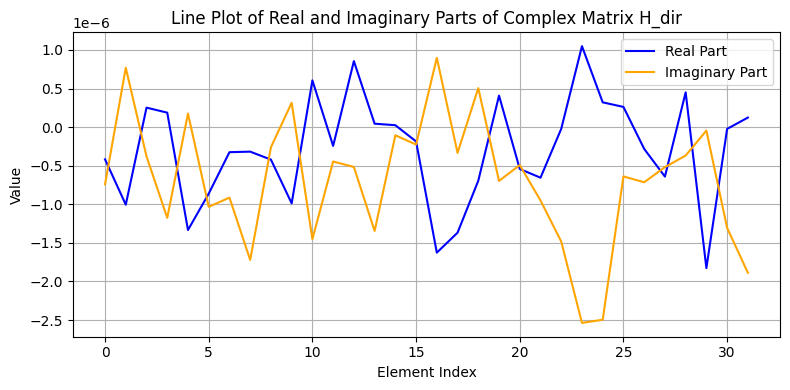

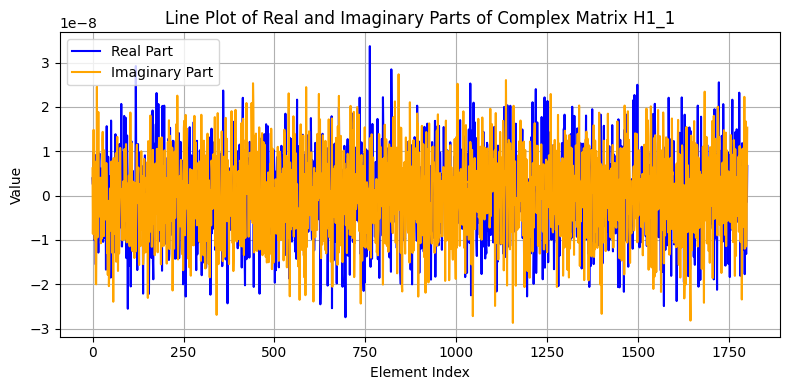

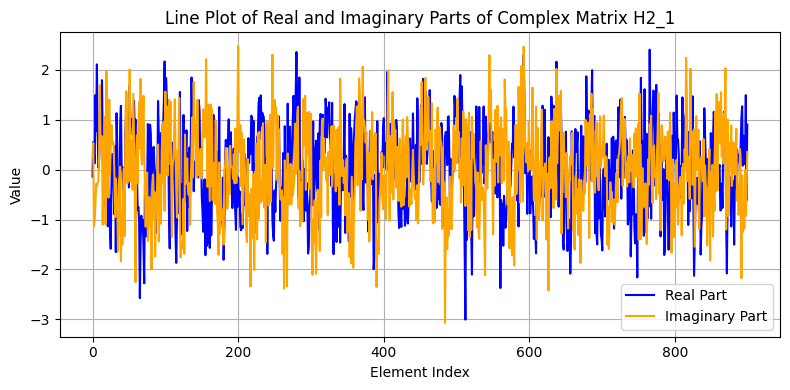

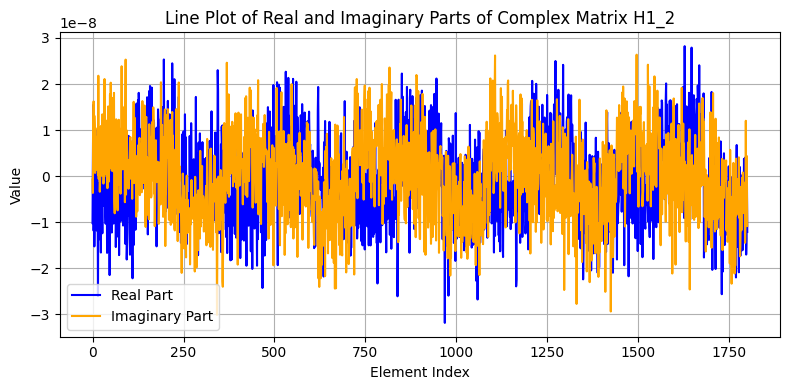

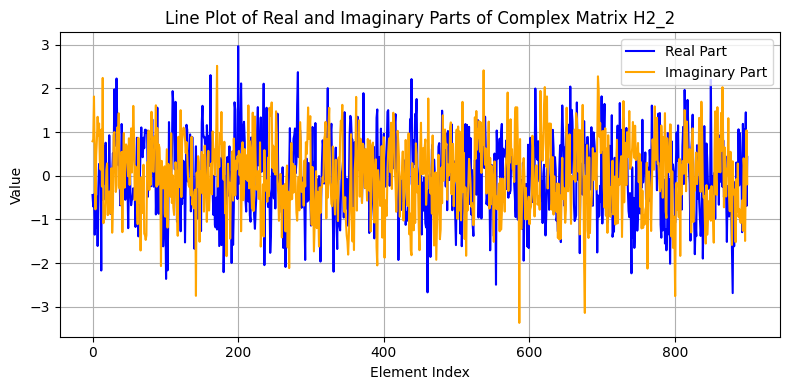

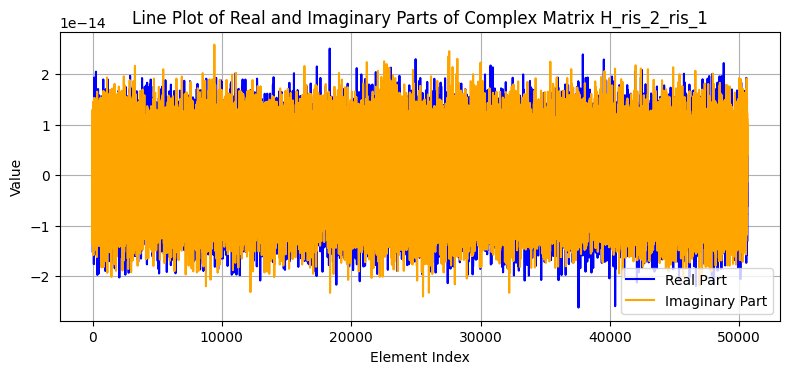

In [12]:
[thetas_1, H_dir, H1_1, H2_1, beta_INDIR_inverse_1] = GenerateChannels(Nt, lt, Nr, lr, D, d_ris, Na_1, Nb_1, wavelength, alpha_dir, racian_factor, distance_r_t, distance_ris_1_t, distance_r_ris_1)
[thetas_2, _, H1_2, H2_2, beta_INDIR_inverse_2] = GenerateChannels(Nt, abs(d_ris_ris_y - lt), Nr, abs(d_ris_ris_y - lr), D, d_ris, Na_2, Nb_2, wavelength, alpha_dir, racian_factor, distance_r_t, distance_ris_2_t, distance_r_ris_2)
[
    H_ris_2_ris_1,
    beta_INDIR_inverse_t_2_1_rx
] = GenerateChannelIRSIRS(lt, lr, D, d_ris, d_ris_ris_x, d_ris_ris_y, Na_1, Nb_1, Na_2, Nb_2, wavelength, racian_factor, distance_ris_2_ris_1)

plot_complex_matrix_line(H_dir, 'H_dir')
plot_complex_matrix_line(np.sqrt(beta_INDIR_inverse_1) * H1_1, 'H1_1')
plot_complex_matrix_line(H2_1, 'H2_1')

plot_complex_matrix_line(np.sqrt(beta_INDIR_inverse_2) * H1_2, 'H1_2')
plot_complex_matrix_line(H2_2, 'H2_2')


plot_complex_matrix_line(np.sqrt(beta_INDIR_inverse_t_2_1_rx) * H_ris_2_ris_1, 'H_ris_2_ris_1')

In [13]:
rate_average_single = np.zeros(max_iterations+1)
rate_average_noninteractive = np.zeros(max_iterations+1)
rate_average_interactive = np.zeros(max_iterations+1)

for i in range(average_over):
    # if(i % 10 !):
    print(f"PGM for {i+1}th channel")
    [thetas_1, H_dir, H1_1, H2_1, beta_INDIR_inverse_1] = GenerateChannels(Nt, lt, Nr, lr, D, d_ris, Na_1, Nb_1, wavelength, alpha_dir, racian_factor, distance_r_t, distance_ris_1_t, distance_r_ris_1)
    [thetas_2, _, H1_2, H2_2, beta_INDIR_inverse_2] = GenerateChannels(Nt, abs(d_ris_ris_y - lt), Nr, abs(d_ris_ris_y - lr), D, d_ris, Na_2, Nb_2, wavelength, alpha_dir, racian_factor, distance_r_t, distance_ris_2_t, distance_r_ris_2)
    [
        H_ris_2_ris_1,
        beta_INDIR_inverse_t_2_1_rx
    ] = GenerateChannelIRSIRS(lt, lr, D, d_ris, d_ris_ris_x, d_ris_ris_y, Na_1, Nb_1, Na_2, Nb_2, wavelength, racian_factor, distance_ris_2_ris_1)
    
    [rates, _, _] = PGM_single(
        max_iterations, H_dir, 
        H1_1, H2_1, beta_INDIR_inverse_1, 
        H1_2, H2_2, beta_INDIR_inverse_2, 
        H_ris_2_ris_1, beta_INDIR_inverse_t_2_1_rx,
        D, intial_Q, thetas_1, thetas_2, noise_power, Pt
    )
    rate_average_single += rates / average_over

    [rates, _, _] = PGM_single_noninteractive(
        max_iterations, H_dir, 
        H1_1, H2_1, beta_INDIR_inverse_1, 
        H1_2, H2_2, beta_INDIR_inverse_2, 
        H_ris_2_ris_1, beta_INDIR_inverse_t_2_1_rx,
        D, intial_Q, thetas_1, thetas_2, noise_power, Pt
    )
    rate_average_noninteractive += rates / average_over

    [rates, _, _] = PGM(
        max_iterations, H_dir, 
        H1_1, H2_1, beta_INDIR_inverse_1, 
        H1_2, H2_2, beta_INDIR_inverse_2, 
        H_ris_2_ris_1, beta_INDIR_inverse_t_2_1_rx,
        D, intial_Q, thetas_1, thetas_2, noise_power, Pt
    )
    rate_average_interactive += rates / average_over
    

# rate_average = rate_average 


PGM for 1th channel
PGM for 2th channel
PGM for 3th channel
PGM for 4th channel
PGM for 5th channel
PGM for 6th channel
PGM for 7th channel
PGM for 8th channel
PGM for 9th channel
PGM for 10th channel


In [16]:
# Create the line plot
normal_rate_fig = go.Figure(data=[go.Scatter(
    x=np.log10(np.arange(0, len(rate_average_single))+1),
    y=rate_average_single, 
    mode='lines',  # Line + Markers
    marker=dict(size=4,),  # Marker style
    line=dict(width=4),  # Line style
    name='Single IRS'
),
go.Scatter(
    x=np.log10(np.arange(0, len(rate_average_noninteractive))+1),
    y=rate_average_noninteractive, 
    mode='lines',  # Line + Markers
    marker=dict(size=4,),  # Marker style
    line=dict(width=4),  # Line style
    name='Non interative IRS'
),
go.Scatter(
    x=np.log10(np.arange(0, len(rate_average_interactive))+1),
    y=rate_average_interactive, 
    mode='lines',  # Line + Markers
    marker=dict(size=4,),  # Marker style
    line=dict(width=4, dash='dot'),  # Line style
    name='Interactive IRS'
)]) 

# Add titles and labels
normal_rate_fig.update_layout(
    title='Achivable Rate (dirs 1 = 40, dirs 2 = 460)',
    xaxis_title='Iteration number',
    yaxis_title='Rate (bit/s/Hz)'
)

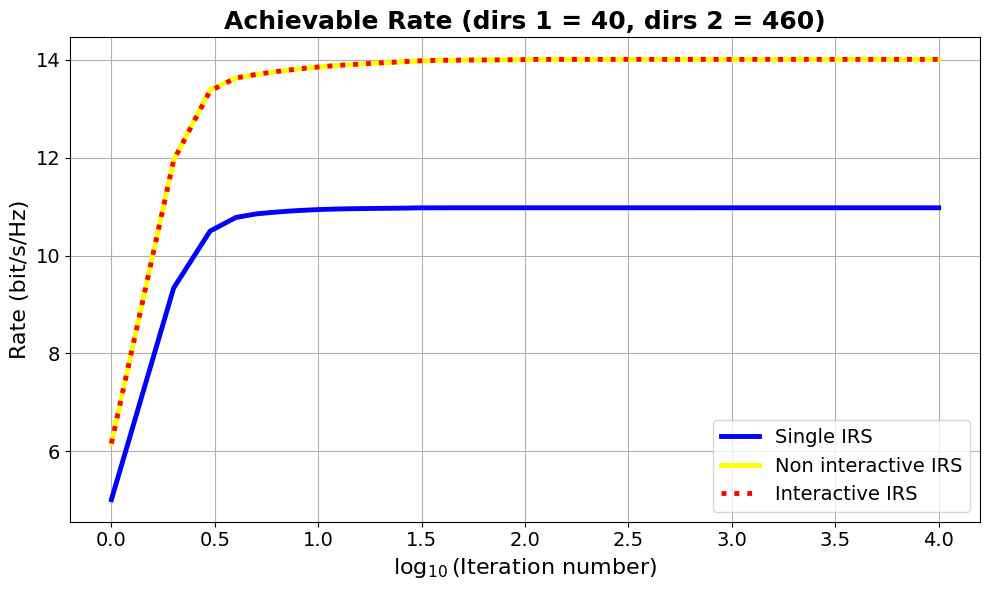

In [18]:

# X-axis
x_vals_single = np.log10(np.arange(1, len(rate_average_single) + 1))
x_vals_noninteractive = np.log10(np.arange(1, len(rate_average_noninteractive) + 1))
x_vals_interactive = np.log10(np.arange(1, len(rate_average_interactive) + 1))

# Create the plot
plt.figure(figsize=(10, 6))

# Plot lines
plt.plot(x_vals_single, rate_average_single, label='Single IRS',
         linewidth=3.5, linestyle='-', color='blue')

plt.plot(x_vals_noninteractive, rate_average_noninteractive, label='Non interactive IRS',
         linewidth=3.5, linestyle='-', color='yellow')

plt.plot(x_vals_interactive, rate_average_interactive, label='Interactive IRS',
         linewidth=3.5, linestyle=':', color='red')

# Add title and axis labels
plt.title('Achievable Rate (dirs 1 = 40, dirs 2 = 460)', fontsize=18, fontweight='bold')
plt.xlabel(r'$\log_{10}(\mathrm{Iteration\ number})$', fontsize=16)
plt.ylabel('Rate (bit/s/Hz)', fontsize=16)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add legend
plt.legend(fontsize=14)

# Grid and layout
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:

max_iterations = 500
average_over = 10
theta_step_size = 10

max_rates = np.zeros(10)
quantized_rate = np.zeros(10)

for theta_step_size in range(1, 11):
    print(f"step size {theta_step_size}")
    qrate_average = np.zeros(max_iterations+1)

    for i in range(average_over):
        [thetas_1, H_dir_1, H1_1, H2_1] = GenerateChannels(Nt, lt_1, Nr, lr_1, D, d_ris_1, Na, Nb, wavelength, alpha_dir, racian_factor)
        [thetas_2, H_dir_2, H1_2, H2_2] = GenerateChannels(Nt, lt_2, Nr, lr_2, D, d_ris_2, Na, Nb, wavelength, alpha_dir, racian_factor)
        [rates, _, _] = PGM_Quantized_last_step(
            max_iterations, 
            H_dir_1, H1_1, H2_1, H_dir_2, H1_2, H2_2, 
            Nr, D, intial_Q, thetas_1, thetas_2, noise_power, Pt,
            2 ** theta_step_size
        )
        
        qrate_average += rates / average_over
        
    max_rates[theta_step_size-1] = qrate_average[-2]
    quantized_rate[theta_step_size-1] = qrate_average[-1]

    
    

step size 1
step size 2
step size 3
step size 4
step size 5
step size 6
step size 7
step size 8
step size 9
step size 10


In [ ]:
# Create traces for real part
mixfigure = go.Figure()
mixfigure.add_trace(go.Scatter(x=np.arange(1, 11), y=max_rates, mode='lines+markers', name='Non qantized'))
mixfigure.add_trace(go.Scatter(x=np.arange(1, 11), y=quantized_rate, mode='lines+markers', name='Quantized'))

# Add titles and labels
mixfigure.update_layout(
    title='Indirect link length (dirs = 40)',
    xaxis_title='Iteration number',
    yaxis_title='Rate (bit/s/Hz)',
    template='plotly_dark',  # Optional: Dark theme, change if needed
)